# Fixing Swiss electricity

To run this notebook, you must have the following environment variables set:

* BENTSO_DATA_DIR: Directory to cache data from ENTSO-E API

In addition, you need to have finished the notebook `ENTSO-E electricity data`.

In [2]:
import bw2data as bd
import bw2io as bi
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [2]:
assert bd.__version__ >= (4, 0, 'DEV11')

In [3]:
bd.projects.set_current('GSA for archetypes')

In [111]:
def get_one(db_name, **kwargs):
    possibles = [act for act in bd.Database(db_name) if all(act.get(key) == value for key, value in kwargs.items())]
    if len(possibles) == 1:
        return possibles[0]
    else:
        raise ValueError(f"Couldn't get exactly one activity in database `{db_name}` for arguments {kwargs}")

In [7]:
ch2019 = pd.read_excel("data/EnergieUebersichtCH-2019.xls", sheet_name="Zeitreihen0h15", usecols=[2], header=1)
ch2020 = pd.read_excel("data/EnergieUebersichtCH-2020.xlsx", sheet_name="Zeitreihen0h15", usecols=[2], header=1)
ch2021 = pd.read_excel("data/EnergieUebersichtCH-2021.xlsx", sheet_name="Zeitreihen0h15", usecols=[2], header=1)

In [21]:
ch2019 = ch2019.groupby(ch2019.index // 4).sum()
ch2020 = ch2020.groupby(ch2020.index // 4).sum()
ch2021 = ch2021.groupby(ch2021.index // 4).sum()

In [5]:
from bentso.constants import ENTSO_COUNTRIES, TRADE_PAIRS

In [11]:
from bentso import CachingDataClient as CDC

In [12]:
cdc = CDC()

Using data directory /Users/cmutel/Code/akula/entso-data-cache


In [8]:
def clean_consumption_values(df):
    df.drop([col for col in df.columns if col[1] == 'Actual Consumption'], axis=1, inplace=True)
    df.columns = df.columns.get_level_values(0)
    return df

In [9]:
def get_df(country, year):
    df = cdc.get_generation(country=country, year=year)
    if isinstance(df.columns, pd.core.indexes.multi.MultiIndex):
        df = clean_consumption_values(df)
    df = df.fillna(0)
    return df

In [22]:
df2019 = get_df('CH', 2019).sum(axis=1)

# Plot differences

In [82]:
N = 800

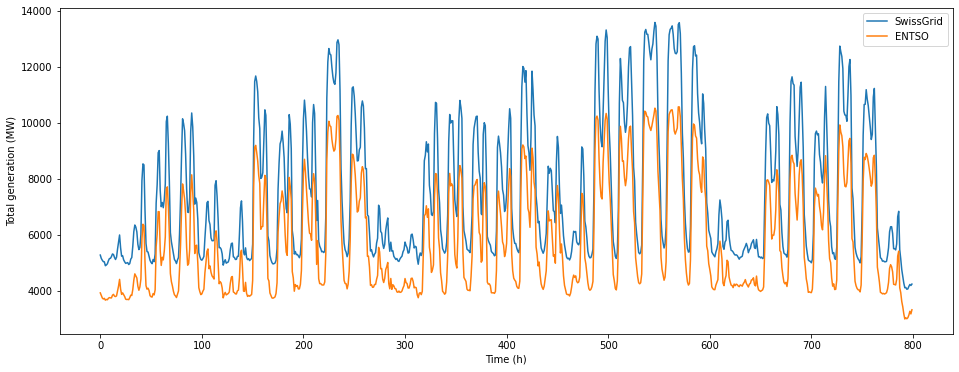

In [83]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(N), ch2019[:N] / 1000, label='SwissGrid')
plt.plot(np.arange(N), df2019[:N], label='ENTSO')
plt.legend()
plt.xlabel("Time (h)")
plt.ylabel("Total generation (MW)")
plt.savefig("SwissGrid versus ENTSO.png")

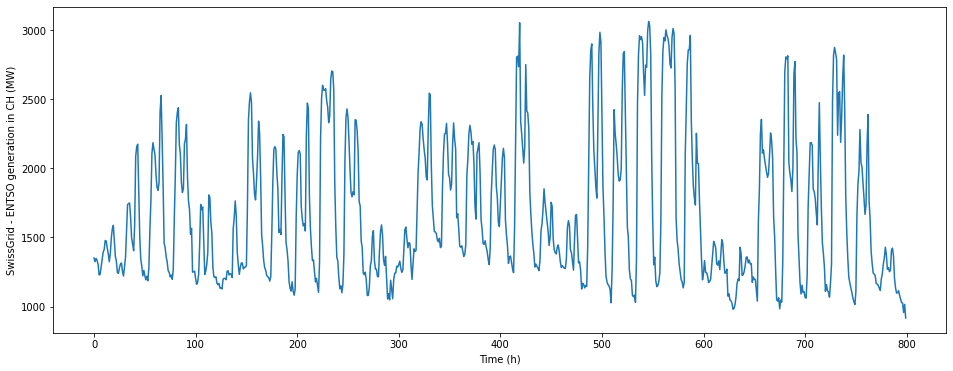

In [84]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(N), ch2019[:N].to_numpy().ravel() / 1000 - df2019[:N].to_numpy(), label='SwissGrid')
plt.xlabel("Time (h)")
plt.ylabel("SwissGrid - ENTSO generation in CH (MW)")
plt.savefig("Absolute difference.png")

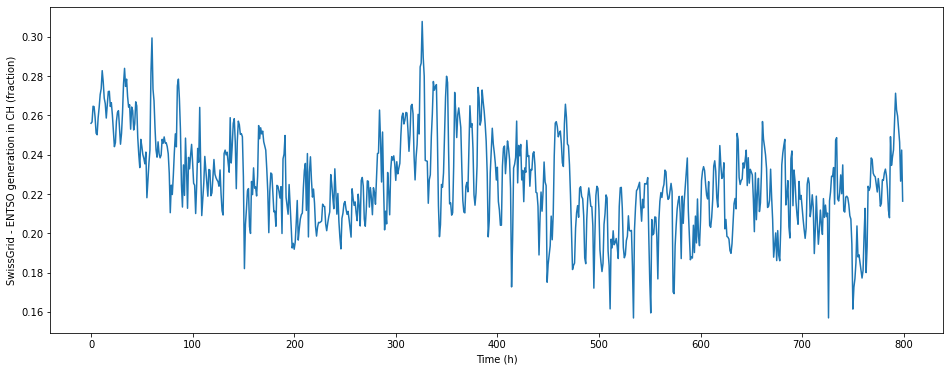

In [85]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(N), (ch2019[:N].to_numpy().ravel() / 1000 - df2019[:N].to_numpy()) / (ch2019[:N].to_numpy().ravel() / 1000), label='SwissGrid')
plt.xlabel("Time (h)")
plt.ylabel("SwissGrid - ENTSO generation in CH (fraction)")
plt.savefig("Fractional difference.png")

# Construct residual mix

This is what ENTSO reports:

In [56]:
get_df('CH', 2019).sum(axis=0) / get_df('CH', 2019).sum(axis=0).sum()

Hydro Pumped Storage               0.160961
Hydro Run-of-river and poundage    0.040801
Hydro Water Reservoir              0.248612
Nuclear                            0.539157
Solar                              0.008793
Wind Onshore                       0.001676
dtype: float64

Mapping of ENTSO labels to ecoinvent:

In [62]:
ENTSO_MAPPING = {
    'Biomass': [
        'heat and power co-generation, wood chips, 6667 kW',
        'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014',
        'heat and power co-generation, biogas, gas engine',
    ],
    'Fossil Brown coal/Lignite': [
        'electricity production, lignite',
        'heat and power co-generation, lignite',
    ],
    'Fossil Coal-derived gas': [
        'treatment of coal gas, in power plant',
    ],
    'Fossil Gas': [
        'electricity production, natural gas, combined cycle power plant',
        'electricity production, natural gas, conventional power plant',
        'heat and power co-generation, natural gas, 500kW electrical, lean burn',
        'heat and power co-generation, natural gas, combined cycle power plant, 400MW electrical',
        'heat and power co-generation, natural gas, conventional power plant, 100MW electrical',
    ],
    'Fossil Hard coal': [
        'electricity production, hard coal',
        'heat and power co-generation, hard coal',
    ],
    'Fossil Oil': [
        'electricity production, oil',
        'heat and power co-generation, oil',
    ],
    'Fossil Oil shale': [
    ],
    'Fossil Peat': [
        'electricity production, peat',
    ],
    'Geothermal': [
        'electricity production, deep geothermal',
    ],
    # This will be a bit funky; could consider charging with average of last 48 hours?
    'Hydro Pumped Storage': [
        'electricity production, hydro, pumped storage',
    ],
    'Hydro Run-of-river and poundage': [
        'electricity production, hydro, run-of-river',
    ],
    'Hydro Water Reservoir': [
        'electricity production, hydro, reservoir, alpine region',
        'electricity production, hydro, reservoir, non-alpine region',
    ],
    'Nuclear': [
        'electricity production, nuclear, boiling water reactor',
        'electricity production, nuclear, pressure water reactor',
        'electricity production, nuclear, pressure water reactor, heavy water moderated',
    ],
    'Other': [
        'treatment of blast furnace gas, in power plant',
    ],
    'Other renewable': [
    ],
    'Solar': [
        'electricity production, photovoltaic, 3kWp facade installation, multi-Si, laminated, integrated',
        'electricity production, photovoltaic, 3kWp facade installation, multi-Si, panel, mounted',
        'electricity production, photovoltaic, 3kWp facade installation, single-Si, laminated, integrated',
        'electricity production, photovoltaic, 3kWp facade installation, single-Si, panel, mounted',
        'electricity production, photovoltaic, 3kWp flat-roof installation, multi-Si',
        'electricity production, photovoltaic, 3kWp flat-roof installation, single-Si',
        'electricity production, photovoltaic, 3kWp slanted-roof installation, CIS, panel, mounted',
        'electricity production, photovoltaic, 3kWp slanted-roof installation, CdTe, laminated, integrated',
        'electricity production, photovoltaic, 3kWp slanted-roof installation, a-Si, laminated, integrated',
        'electricity production, photovoltaic, 3kWp slanted-roof installation, a-Si, panel, mounted',
        'electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, laminated, integrated',
        'electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted',
        'electricity production, photovoltaic, 3kWp slanted-roof installation, ribbon-Si, laminated, integrated',
        'electricity production, photovoltaic, 3kWp slanted-roof installation, ribbon-Si, panel, mounted',
        'electricity production, photovoltaic, 3kWp slanted-roof installation, single-Si, laminated, integrated',
        'electricity production, photovoltaic, 3kWp slanted-roof installation, single-Si, panel, mounted',
        'electricity production, photovoltaic, 570kWp open ground installation, multi-Si',
        'electricity production, solar thermal parabolic trough, 50 MW',
        'electricity production, solar tower power plant, 20 MW',        
    ],
    'Waste': [
        'electricity, from municipal waste incineration to generic market for electricity, medium voltage',
    ],
    'Wind Offshore': [
        'electricity production, wind, 1-3MW turbine, offshore',
    ],
    'Wind Onshore': [
        'electricity production, wind, 1-3MW turbine, onshore',
        'electricity production, wind, <1MW turbine, onshore',
        'electricity production, wind, >3MW turbine, onshore',
    ],
}

In [112]:
MRKT = "market for electricity, high voltage"

In [113]:
def is_generation_exchange(exc):
    return (exc.input['unit'] == 'kilowatt hour' 
        and "import from" not in exc.input['name'] 
        and not exc.input['name'].startswith('market')
        and 'voltage transformation' not in exc.input['name']
    )

In [115]:
unnormalized_ecoinvent_mix = [
    (exc['amount'], exc.input['name']) 
    for exc in get_one(
        "ecoinvent 3.8 cutoff",
        name="market for electricity, high voltage",
        location='CH'
    ).technosphere() 
    if is_generation_exchange(exc)
]
unnormalized_ecoinvent_mix

[(0.000654817860303059, 'electricity production, wind, >3MW turbine, onshore'),
 (0.00413791636637647,
  'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014'),
 (0.284752720597283,
  'electricity production, hydro, reservoir, alpine region'),
 (0.249318405588984, 'electricity production, hydro, run-of-river'),
 (0.0908550645788571,
  'electricity production, nuclear, boiling water reactor'),
 (0.102073623581874,
  'electricity production, nuclear, pressure water reactor'),
 (0.0017346372101015, 'electricity production, wind, 1-3MW turbine, onshore'),
 (0.000284949834528766, 'electricity production, wind, <1MW turbine, onshore'),
 (0.020528823816395, 'heat and power co-generation, biogas, gas engine'),
 (0.00227096369156559,
  'heat and power co-generation, natural gas, 500kW electrical, lean burn')]

In [89]:
def get_normalized_ecoinvent_mix(unnormalized_ecoinvent_mix):
    total = sum(x[0] for x in unnormalized_ecoinvent_mix)
    return sorted([(x[0]/total, x[1]) for x in unnormalized_ecoinvent_mix], reverse=True)

normalized_ecoinvent_mix = get_normalized_ecoinvent_mix(unnormalized_ecoinvent_mix)
normalized_ecoinvent_mix

[(0.3763524098598716,
  'electricity production, hydro, reservoir, alpine region'),
 (0.3295195303806706, 'electricity production, hydro, run-of-river'),
 (0.1349088224252571,
  'electricity production, nuclear, pressure water reactor'),
 (0.12008146025964041,
  'electricity production, nuclear, boiling water reactor'),
 (0.02713256715750832, 'heat and power co-generation, biogas, gas engine'),
 (0.00546900761129812,
  'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014'),
 (0.003001490753915329,
  'heat and power co-generation, natural gas, 500kW electrical, lean burn'),
 (0.002292637952272941,
  'electricity production, wind, 1-3MW turbine, onshore'),
 (0.0008654606678644406,
  'electricity production, wind, >3MW turbine, onshore'),
 (0.000376612931701331, 'electricity production, wind, <1MW turbine, onshore')]

In [75]:
def get_ecoinvent_as_entso(normalized_ecoinvent_mix):
    ecoinvent_as_entso = defaultdict(float)

    reversed_mapping  = {elem: key for key, value in ENTSO_MAPPING.items() for elem in value}

    for x, y in normalized:
        ecoinvent_as_entso[reversed_mapping[y]] += x

    return ecoinvent_as_entso

ecoinvent_as_entso = get_ecoinvent_as_entso(normalized_ecoinvent_mix)
ecoinvent_as_entso

defaultdict(float,
            {'Hydro Water Reservoir': 0.3763524098598716,
             'Hydro Run-of-river and poundage': 0.3295195303806706,
             'Nuclear': 0.2549902826848975,
             'Biomass': 0.032601574768806436,
             'Fossil Gas': 0.003001490753915329,
             'Wind Onshore': 0.003534711551838713})

In [76]:
def get_difference_dict(ecoinvent_as_entso, aggregated_entso_dict):
    diff_dict = {key: value - entso_dict.get(key, 0) 
                 for key, value in ecoinvent_as_entso.items() 
                 if value - entso_dict.get(key, 0) > 0}

    diff_dict_total = sum(diff_dict.values())

    return {k: v / diff_dict_total for k, v in diff_dict.items()}

In [77]:
residual_mix = get_difference_dict(
    ecoinvent_as_entso,
    (get_df('CH', 2019).sum(axis=0) / get_df('CH', 2019).sum(axis=0).sum()).to_dict()
)
residual_mix

{'Hydro Water Reservoir': 0.2814150228066876,
 'Hydro Run-of-river and poundage': 0.636056236216345,
 'Biomass': 0.07182225700693869,
 'Fossil Gas': 0.006612375072688834,
 'Wind Onshore': 0.004094108897339887}

Translate to ecoinvent activities

In [92]:
def get_residual_mix_in_ecoinvent_nomenclature(residual_mix, unnormalized_ecoinvent_mix):
    result = {}
    
    for key, value in residual_mix.items():
        activities = [(x, y) for x, y in unnormalized_ecoinvent_mix if y in ENTSO_MAPPING[key]]
        total = sum(x[0] for x in activities)
        result.update(**{label: amount / total * value for amount, label in activities})
        
    return result

residual_mix_in_ecoinvent_nomenclature = get_residual_mix_in_ecoinvent_nomenclature(residual_mix, unnormalized_ecoinvent_mix)
residual_mix_in_ecoinvent_nomenclature

{'electricity production, hydro, reservoir, alpine region': 0.2814150228066876,
 'electricity production, hydro, run-of-river': 0.636056236216345,
 'heat and power co-generation, wood chips, 6667 kW, state-of-the-art 2014': 0.012048389472504549,
 'heat and power co-generation, biogas, gas engine': 0.059773867534434144,
 'heat and power co-generation, natural gas, 500kW electrical, lean burn': 0.006612375072688834,
 'electricity production, wind, >3MW turbine, onshore': 0.0010024269784498687,
 'electricity production, wind, 1-3MW turbine, onshore': 0.0026554668750543753,
 'electricity production, wind, <1MW turbine, onshore': 0.00043621504383564323}